In [1]:
## UROP exploration
# Study on HITLAPOMDPirconEnvironment with POMDP (using votes) against HITLDRNAgent
# Converges!
# Trying different learning parameters with same agent
# TODO:


# Training HITLDRQAgent appears to not converge using default learning parameters WHEN hiddent states are not reset after every episode
# NOTE: Hidden state is reset at the start of any episode during training -> reward values might be affected whenever there is a change in hidden states

In [1]:
# from gym_examples.utils.population import PopulationSimulation
# import pandas as pd
# population = PopulationSimulation(2.9, 1.05, 0.5, 0.25, 10, 2, irrational=True, irrational_B=100)
# population.irrationality_score(pd.Series([3.53, 3.48, 0.88, 1.71, 1.3,  1.89, 3.39]))
# Irrational values should be between 0 and 500 (basically rational and always chose true pmv)

array([3, 3, 1, 2, 1, 2, 3])

In [1]:
# Import and initialise device param
import time
from models.BaseAgent import BaseAgent
import gymnasium as gym
import torch
import numpy as np
from gym_examples.utils.population import PopulationSimulation
from models.HITLDQNAgent import HITLDQNAgent
from models.HITLDRQNAgent import HITLDRQNAgent

device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "mps" if torch.backends.mps.is_available() else
    "cpu"
)

In [2]:
def train_w_reset_h(agent:BaseAgent, env:gym.Env, episodes: int, device, is_exploring:bool):
    """Train agent using gym environment while being offline"""

    rewards = []

    agent.reset_replay_memory() # Same train function has the same episodic memory
    agent.set_exploring(True)

    i = 0 # TODO: Remove

    for i_episode in range(episodes):
        print(f'######------------------------------------EPISODE {i_episode}------------------------------------######')
        observation, info = env.reset()
        state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)
        ep_rewards = 0
        is_done = False

        while not is_done:
            # print("\n----Step----")
            # start = time.time()
            # start_a = time.time()
            action = agent.select_action(state)
            # end_a = time.time()
            # print(f'Action selection duration:{end_a-start_a}')
            # start_s = time.time()
            observation, reward, terminated, truncated, info = env.step(action.item())
            # end_s = time.time()
            # print(f'Step duration:{end_s-start_s}')
            reward = torch.tensor([np.float32(reward)], device=device)
            ep_rewards += reward
            
            is_done = terminated or truncated
            next_state = None if terminated else torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)
            # start_m = time.time()
            agent.memorize(state, action, next_state, reward)
            # end_m = time.time()
            # print(f'Memorize duration:{end_m - start_m}')
            state = next_state
            # start_o = time.time()
            agent.optimize_model()
            # end_o = time.time()
            # print(f'Optimization selection duration:{end_o-start_o}')

            # end = time.time()
            # print(f'Iteration duration:{end-start}')


        rewards.append(ep_rewards.item())

        agent.reset_hidden_state() # Reset the hidden state of the agent

    return agent, rewards

######------------------------------------Resetting environment...------------------------------------######
######------------------------------------Starting training...------------------------------------######
######------------------------------------EPISODE 0------------------------------------######
######------------------------------------EPISODE 1------------------------------------######
######------------------------------------EPISODE 2------------------------------------######
######------------------------------------EPISODE 3------------------------------------######


/Users/waishunlee/Documents/UROP/hitl_hvac/models/HITLDRQNAgent.py:151: UserWarning: MPS: nonzero op is supported natively starting from macOS 13.0. Falling back on CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/mps/operations/Indexing.mm:334.)
  next_state_values[non_final_mask] = self.target_net(non_final_next_states).max(1).values


######------------------------------------EPISODE 4------------------------------------######
######------------------------------------EPISODE 5------------------------------------######
######------------------------------------EPISODE 6------------------------------------######
######------------------------------------EPISODE 7------------------------------------######
######------------------------------------EPISODE 8------------------------------------######
######------------------------------------EPISODE 9------------------------------------######
######------------------------------------EPISODE 10------------------------------------######
######------------------------------------EPISODE 11------------------------------------######
######------------------------------------EPISODE 12------------------------------------######
######------------------------------------EPISODE 13------------------------------------######
######------------------------------------EPISODE 14----

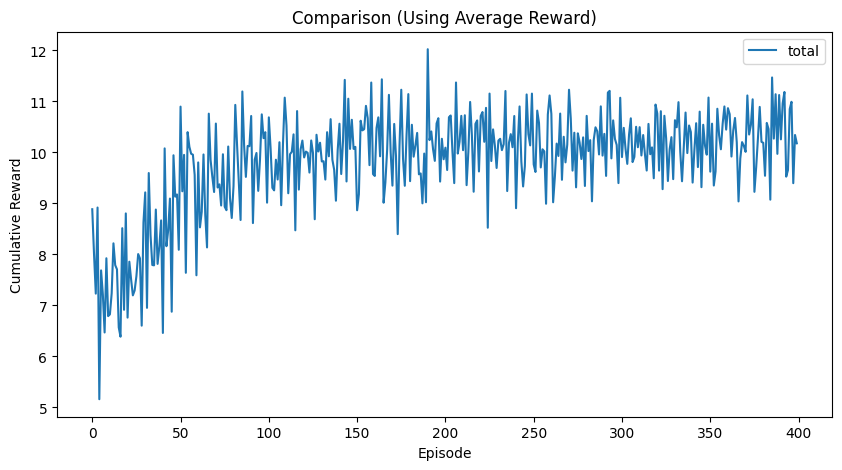

In [3]:
# Default training parameters

# population = PopulationSimulation(2.9, 1.05, 0.5, 0.25, 200, 80)
population = PopulationSimulation(2.9, 1.05, 0.5, 0.25, 10, 2, irrational=True, irrational_B=0.5)

# w_energy, w_usercomfort is from generated from a comfort score of range (-40 - 0) and power score (-1000 - -300) 100:1
env = gym.make("HITLAPOMDPirconEnvironment-v0", population_simulation=population, is_render=False, check_optimal=False ,w_usercomfort=1)
print("######------------------------------------Resetting environment...------------------------------------######")

state, info = env.reset()
n_observations = len(state)
n_actions = env.action_space.n

agent = HITLDRQNAgent(n_observations, n_actions, device, 
                     memory_size=10000, 
                     batch_size=64, 
                     gamma=0.99, 
                     eps_start=0.9, 
                     eps_end=0.05, 
                     eps_decay=1000, 
                     tau=0.005, 
                     lr=1e-4)

NUM_EPISODES = 400 if torch.cuda.is_available() or torch.backends.mps.is_available() else 50 # Number of days (each episode is a day)
# NUM_EPISODES = 20 if torch.cuda.is_available() or torch.backends.mps.is_available() else 50 # Number of days (each episode is a day)

print("######------------------------------------Starting training...------------------------------------######")
agent, rewards = train_w_reset_h(agent, env, NUM_EPISODES, device, True)

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(rewards, label='total')
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')
plt.title('Comparison (Using Average Reward)')
plt.legend()

plt.ioff()
plt.show()

######------------------------------------Resetting environment...------------------------------------######
######------------------------------------Starting training...------------------------------------######
######------------------------------------EPISODE 0------------------------------------######
######------------------------------------EPISODE 1------------------------------------######
######------------------------------------EPISODE 2------------------------------------######
######------------------------------------EPISODE 3------------------------------------######
######------------------------------------EPISODE 4------------------------------------######
######------------------------------------EPISODE 5------------------------------------######
######------------------------------------EPISODE 6------------------------------------######
######------------------------------------EPISODE 7------------------------------------######
######----------------------------

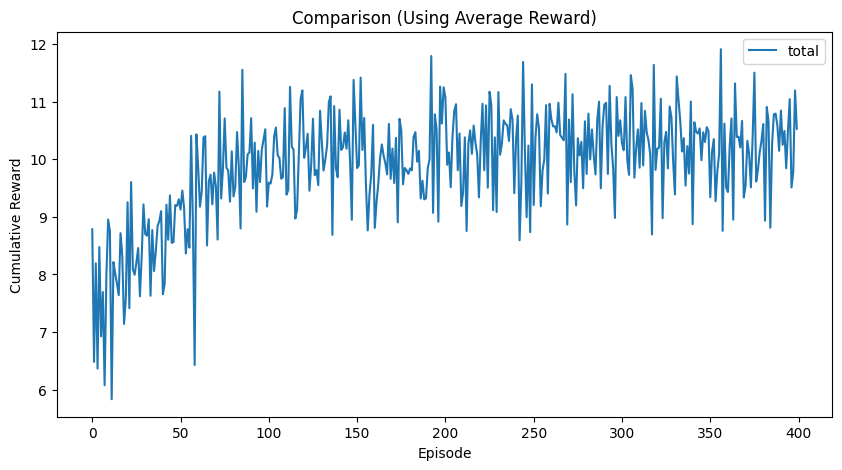

In [4]:
# Default training parameters

# population = PopulationSimulation(2.9, 1.05, 0.5, 0.25, 200, 80)
population = PopulationSimulation(2.9, 1.05, 0.5, 0.25, 10, 2, irrational=True, irrational_B=1)

# w_energy, w_usercomfort is from generated from a comfort score of range (-40 - 0) and power score (-1000 - -300) 100:1
env = gym.make("HITLAPOMDPirconEnvironment-v0", population_simulation=population, is_render=False, check_optimal=False ,w_usercomfort=1)
print("######------------------------------------Resetting environment...------------------------------------######")

state, info = env.reset()
n_observations = len(state)
n_actions = env.action_space.n

agent = HITLDRQNAgent(n_observations, n_actions, device, 
                     memory_size=10000, 
                     batch_size=64, 
                     gamma=0.99, 
                     eps_start=0.9, 
                     eps_end=0.05, 
                     eps_decay=1000, 
                     tau=0.005, 
                     lr=1e-4)

NUM_EPISODES = 400 if torch.cuda.is_available() or torch.backends.mps.is_available() else 50 # Number of days (each episode is a day)
# NUM_EPISODES = 20 if torch.cuda.is_available() or torch.backends.mps.is_available() else 50 # Number of days (each episode is a day)

print("######------------------------------------Starting training...------------------------------------######")
agent, rewards = train_w_reset_h(agent, env, NUM_EPISODES, device, True)

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(rewards, label='total')
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')
plt.title('Comparison (Using Average Reward)')
plt.legend()

plt.ioff()
plt.show()

######------------------------------------Resetting environment...------------------------------------######
######------------------------------------Starting training...------------------------------------######
######------------------------------------EPISODE 0------------------------------------######
######------------------------------------EPISODE 1------------------------------------######
######------------------------------------EPISODE 2------------------------------------######
######------------------------------------EPISODE 3------------------------------------######
######------------------------------------EPISODE 4------------------------------------######
######------------------------------------EPISODE 5------------------------------------######
######------------------------------------EPISODE 6------------------------------------######
######------------------------------------EPISODE 7------------------------------------######
######----------------------------

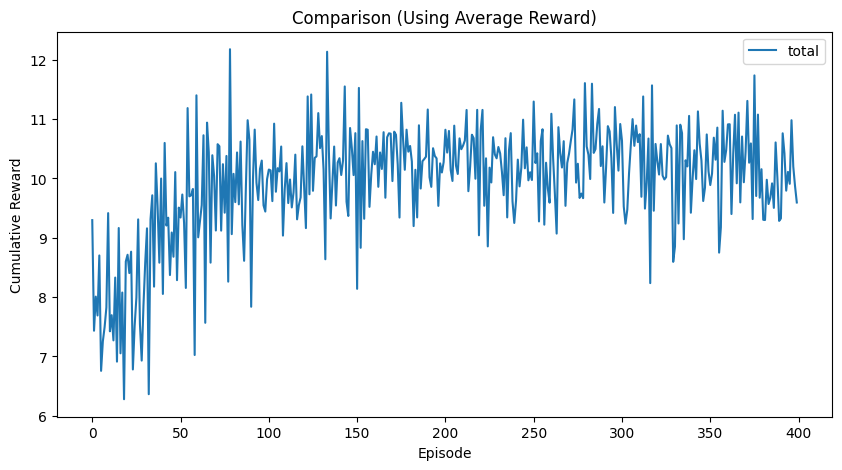

In [6]:
# Default training parameters

# population = PopulationSimulation(2.9, 1.05, 0.5, 0.25, 200, 80)
population = PopulationSimulation(2.9, 1.05, 0.5, 0.25, 10, 2, irrational=True, irrational_B=0.1)

# w_energy, w_usercomfort is from generated from a comfort score of range (-40 - 0) and power score (-1000 - -300) 100:1
env = gym.make("HITLAPOMDPirconEnvironment-v0", population_simulation=population, is_render=False, check_optimal=False ,w_usercomfort=1)
print("######------------------------------------Resetting environment...------------------------------------######")

state, info = env.reset()
n_observations = len(state)
n_actions = env.action_space.n

agent = HITLDRQNAgent(n_observations, n_actions, device, 
                     memory_size=10000, 
                     batch_size=64, 
                     gamma=0.99, 
                     eps_start=0.9, 
                     eps_end=0.05, 
                     eps_decay=1000, 
                     tau=0.005, 
                     lr=1e-4)

NUM_EPISODES = 400 if torch.cuda.is_available() or torch.backends.mps.is_available() else 50 # Number of days (each episode is a day)
# NUM_EPISODES = 20 if torch.cuda.is_available() or torch.backends.mps.is_available() else 50 # Number of days (each episode is a day)

print("######------------------------------------Starting training...------------------------------------######")
agent, rewards = train_w_reset_h(agent, env, NUM_EPISODES, device, True)

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(rewards, label='total')
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')
plt.title('Comparison (Using Average Reward)')
plt.legend()

plt.ioff()
plt.show()

######------------------------------------Resetting environment...------------------------------------######
######------------------------------------Starting training...------------------------------------######
######------------------------------------EPISODE 0------------------------------------######
######------------------------------------EPISODE 1------------------------------------######
######------------------------------------EPISODE 2------------------------------------######
######------------------------------------EPISODE 3------------------------------------######
######------------------------------------EPISODE 4------------------------------------######
######------------------------------------EPISODE 5------------------------------------######
######------------------------------------EPISODE 6------------------------------------######
######------------------------------------EPISODE 7------------------------------------######
######----------------------------

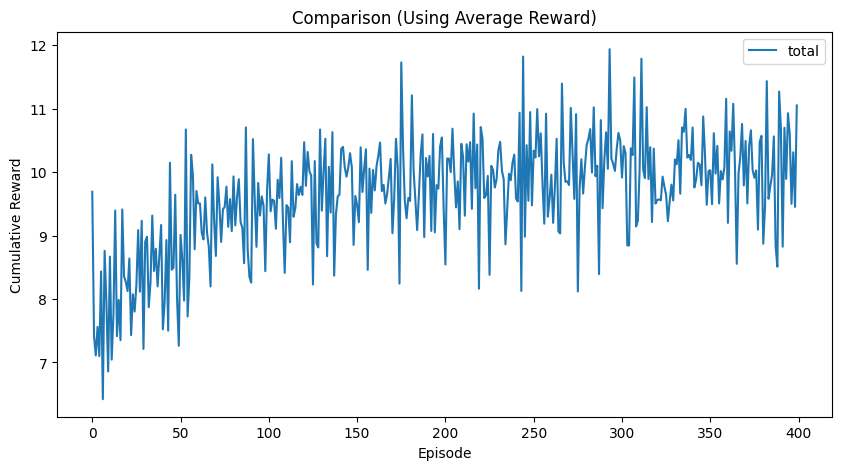

In [7]:
# Default training parameters

# population = PopulationSimulation(2.9, 1.05, 0.5, 0.25, 200, 80)
population = PopulationSimulation(2.9, 1.05, 0.5, 0.25, 10, 2, irrational=True, irrational_B=0.1)

# w_energy, w_usercomfort is from generated from a comfort score of range (-40 - 0) and power score (-1000 - -300) 100:1
env = gym.make("HITLAPOMDPirconEnvironment-v0", population_simulation=population, is_render=False, check_optimal=False ,w_usercomfort=1)
print("######------------------------------------Resetting environment...------------------------------------######")

state, info = env.reset()
n_observations = len(state)
n_actions = env.action_space.n

agent = HITLDRQNAgent(n_observations, n_actions, device, 
                     memory_size=10000, 
                     batch_size=128, 
                     gamma=0.99, 
                     eps_start=0.9, 
                     eps_end=0.05, 
                     eps_decay=1000, 
                     tau=0.005, 
                     lr=1e-4)

NUM_EPISODES = 400 if torch.cuda.is_available() or torch.backends.mps.is_available() else 50 # Number of days (each episode is a day)
# NUM_EPISODES = 20 if torch.cuda.is_available() or torch.backends.mps.is_available() else 50 # Number of days (each episode is a day)

print("######------------------------------------Starting training...------------------------------------######")
agent, rewards = train_w_reset_h(agent, env, NUM_EPISODES, device, True)

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(rewards, label='total')
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')
plt.title('Comparison (Using Average Reward)')
plt.legend()

plt.ioff()
plt.show()

In [ ]:
import numpy as np

def softmax_probabilities(values, v0):
    """
    Computes the softmax probabilities for transitioning from v0 to each value in values.
    
    Args:
    values (np.ndarray): The possible values to transition to.
    v0 (np.ndarray): The current value, vectorized for each person.
    
    Returns:
    np.ndarray: The softmax probabilities for each possible transition for each person.
    """
    # Calculate the numerator of the softmax function for all v0 and values
    numerators = np.exp(values[:] - v0)

    print(-np.abs(values[:, None])- v0, v0)
    numerators = np.exp(-np.abs(values[:, None] - v0))
    print("numerator", numerators.shape, numerators)
    # Calculate the denominator of the softmax function (sum of all numerators)
    denominator = np.sum(numerators, axis=0)
    print("denominator", denominator.shape, denominator)
    # Calculate the softmax probabilities
    probabilities = numerators / denominator
    return probabilities

def generate_irrational_pmv(v0_values):
    """
    Generates the irrational probability mass vectors (pmv) for each person given their true pmvs.
    
    Args:
    v0_values (np.ndarray): The list of current values for each person.
    B_values (np.ndarray): The list of true pmvs for each person.
    
    Returns:
    np.ndarray: The irrational pmvs for each person.
    """
    # Define the possible values from -3 to 3
    possible_values = np.arange(-3, 4)
    
    # Compute the softmax probabilities for all v0 values
    pmv_matrix = softmax_probabilities(possible_values, v0_values)
    
    # Generate random choices based on the softmax probabilities
    chosen_values = np.array([np.random.choice(possible_values, p=pmv_matrix[:, i]) for i in range(len(v0_values))])
    
    return chosen_values

# Example usage
v0_values = np.array([1, -2, 0, 3])  # Example v0 values for each person
B_values = np.array([0.5, 0.8, 0.6, 0.7])  # Example B values for each person (though B_values is not used here)

chosen_values = generate_irrational_pmv(v0_values)
print(chosen_values)


[[-4 -1 -3 -6]
 [-3  0 -2 -5]
 [-2  1 -1 -4]
 [-1  2  0 -3]
 [-2  1 -1 -4]
 [-3  0 -2 -5]
 [-4 -1 -3 -6]] [ 1 -2  0  3]
numerator (7, 4) [[0.01831564 0.36787944 0.04978707 0.00247875]
 [0.04978707 1.         0.13533528 0.00673795]
 [0.13533528 0.36787944 0.36787944 0.01831564]
 [0.36787944 0.13533528 1.         0.04978707]
 [1.         0.04978707 0.36787944 0.13533528]
 [0.36787944 0.01831564 0.13533528 0.36787944]
 [0.13533528 0.00673795 0.04978707 1.        ]]
denominator (4,) [2.07453216 1.94593482 2.10600359 1.58053413]
[ 0 -2  0  2]


In [ ]:
def irrationality_score(pmv:np.ndarray, B=1):
    """Given an array of pmv score, apply irrationality to it and return an array of new pmvs of the same size"""
    v0_stack = np.repeat(pmv, 7).reshape(-1, 7)
    
    possible_values = np.tile(np.arange(-3, 4), v0_values.shape[0]).reshape(-1, 7)
    numerators = np.exp(-np.abs(v0_stack - possible_values) * B)
    denominator = np.sum(numerators, axis=1, keepdims=True)
    probabilities = numerators / denominator
    cumulative_probabilities = np.cumsum(probabilities, axis=1)
    random_samples = np.random.rand(v0_values.shape[0], 1)
    chosen_indices = np.array([np.searchsorted(cumulative_probabilities[i], random_samples[i]) for i in range(len(v0_values))]).flatten()
    chosen_values = possible_values[np.arange(len(v0_values)), chosen_indices]
    return chosen_values

print(irrationality_score(np.array([1, -2])))
print(irrationality_score(np.array([1, -2])))
print(irrationality_score(np.array([1, -2])))
print(irrationality_score(np.array([1, -2])))
print(irrationality_score(np.array([1, -2])))
print(irrationality_score(np.array([1, -2])))
print(irrationality_score(np.array([1, -2])))
print(irrationality_score(np.array([1, -2])))
print(irrationality_score(np.array([1, -2])))
print(irrationality_score(np.array([1, -2])))
print(irrationality_score(np.array([1, -2])))
print(irrationality_score(np.array([1, -2])))
print(irrationality_score(np.array([1, -2])))
print(irrationality_score(np.array([1, -2])))
print(irrationality_score(np.array([1, -2])))
print(irrationality_score(np.array([1, -2])))


[ 1 -1]
[ 2 -3]
[ 0 -2]
[ 2 -1]
[ 1 -3]
[ 0 -2]
[ 1 -1]
[-2 -2]
[ 1 -3]
[ 0 -2]
[ 1 -2]
[ 0 -2]
[ 1 -1]
[ 1 -2]
[ 1 -1]
[ 2 -2]


In [ ]:
v0_values = np.array([1, -2])
v0_stack = np.repeat(v0_values, 7).reshape(-1, 7)
# print(v0_stack)

possible_values = np.tile(np.arange(-3, 4), v0_values.shape[0]).reshape(-1, 7)
# print(possible_values)

# print(np.abs(v0_stack - possible_values))

B = 0.5

numerators = np.exp(-np.abs(v0_stack - possible_values) * B)
# print(numerators)

denominator = np.sum(numerators, axis=1, keepdims=True)
# print(denominator)

probabilities = numerators / denominator
print(probabilities)

# Compute cumulative probabilities
cumulative_probabilities = np.cumsum(probabilities, axis=1)
print(cumulative_probabilities)

# Generate random samples for each row
random_samples = np.random.rand(v0_values.shape[0], 1)
print(random_samples)

# Find the indices where the random samples fit into the cumulative probabilities
chosen_indices = np.array([np.searchsorted(cumulative_probabilities[i], random_samples[i]) for i in range(len(v0_values))]).flatten()
print(chosen_indices)

# Map the indices to the possible values
# chosen_values = possible_values[np.arange(len(v0_values))[:, None], chosen_indices[:, None]].flatten()
# print(chosen_values)

# Compute cumulative probabilities
cumulative_probabilities = np.cumsum(probabilities, axis=1)
# print(cumulative_probabilities)

# Generate random samples for each row
random_samples = np.random.rand(v0_values.shape[0], 1)
# print(random_samples)

# Find the indices where the random samples fit into the cumulative probabilities
chosen_indices = np.argmax(random_samples < cumulative_probabilities, axis=1)
# print(chosen_indices)

# Map the indices to the possible values
chosen_values = possible_values[np.arange(len(v0_values)), chosen_indices]
print(chosen_values)



[[0.04092035 0.06746625 0.11123304 0.18339228 0.30236276 0.18339228
  0.11123304]
 [0.20073885 0.33096241 0.20073885 0.12175427 0.07384769 0.04479089
  0.02716705]]
[[0.04092035 0.1083866  0.21961964 0.40301192 0.70537468 0.88876696
  1.        ]
 [0.20073885 0.53170125 0.7324401  0.85419437 0.92804206 0.97283295
  1.        ]]
[[0.92033817]
 [0.33048053]]
[6 1]


In [ ]:
import numpy as np

def softmax_probabilities(values, v0_values):
    """
    Computes the softmax probabilities for transitioning from v0 to each value in values.
    
    Args:
    values (np.ndarray): The possible values to transition to.
    v0_values (np.ndarray): The current values, vectorized for each person.
    
    Returns:
    np.ndarray: The softmax probabilities for each possible transition for each person.
    """
    # Calculate the absolute differences and apply exponential function
    diff_matrix = np.abs(values[:, None] - v0_values)
    exp_matrix = np.exp(-diff_matrix)
    
    # Calculate the sum of exponentials for each v0
    sum_exp = np.sum(exp_matrix, axis=0)
    
    # Calculate the softmax probabilities
    probabilities = exp_matrix / sum_exp
    
    return probabilities

def generate_irrational_pmv(v0_values, B_values):
    """
    Generates the irrational probability mass vectors (pmv) for each person given their true pmvs.
    
    Args:
    v0_values (np.ndarray): The list of current values for each person.
    B_values (np.ndarray): The list of true pmvs for each person (not used in the calculation).
    
    Returns:
    np.ndarray: The chosen values for each person based on softmax probabilities.
    """
    # Define the possible values from -3 to 3
    possible_values = np.arange(-3, 4)
    
    # Compute the softmax probabilities for all v0 values
    pmv_matrix = softmax_probabilities(possible_values, v0_values)
    
    # Generate random choices based on the softmax probabilities
    chosen_indices = np.array([np.random.choice(len(possible_values), p=pmv_matrix[:, i]) for i in range(len(v0_values))])
    chosen_values = possible_values[chosen_indices]
    
    return chosen_values

# Example usage
v0_values = np.array([1, -2, 0, 3])  # Example v0 values for each person
B_values = np.array([0.5, 0.8, 0.6, 0.7])  # 0 is completely random, inf is completely rational

chosen_values = generate_irrational_pmv(v0_values, B_values)
print(chosen_values)


[ 1 -3  0  2]
